Working with ASCAT data and Xarray
==================================



## Working with swath files



### Creating a SwathFileCollection



If we have a collection of time-series swath files, we can create a SwathFileCollection object that will handle them as a group.



In [1]:
from datetime import datetime
from importlib import reload

import ascat.read_native.ragged_array_ts as rat
from ascat.read_native import xarray_io

from time import time

In [2]:
swath_source = "/home/charriso/p14/data-write/RADAR/hsaf/h121_v1.0/swaths"

It&rsquo;s important to understand the structure of the data, so that the SwathFileCollection can find and parse all of the data that is requested from it. Handily, this package comes with existing parsers for several ASCAT products. These can be used with `SwathFileCollection.from_product_id()`:



In [3]:
swath_collection = rat.SwathFileCollection.from_product_id(swath_source, "H121_V1.0")

The currently included project ids are the keys of `ascat.read_native.xarray_io.swath_io_catalog`



In [4]:
from ascat.read_native.xarray_io import swath_io_catalog
swath_io_catalog.keys()

dict_keys(['H129', 'H129_V1.0', 'H121_V1.0', 'H122', 'SIG0_6.25', 'SIG0_12.5'])

If your data structure does not match anything included in the package, you can write a class inheriting from `ascat.read_native.xarray_io.SwathIOBase`:



In [1]:
class AscatH121v1Swath(SwathIOBase):
    # outlines the basic structure of the swath filenames, with {bracketed} variable names
    # in the place of anything that changes according to the data inside
    fn_pattern = "W_IT-HSAF-ROME,SAT,SSM-ASCAT-METOP{sat}-12.5km-H121_C_LIIB_{placeholder}_{placeholder1}_{date}____.nc"

    # defines the names of the subfolder/directory names that contain the data. In this case,
    # files are sorted into folders by satellite and year, so that a typical filepath looks like
    # ".../metop_b/2021/W_IT-HSAF-ROME..."
    sf_pattern = {
        "satellite_folder": "metop_[abc]",
        "year_folder": "{year}"
    }

    # specifies the string format of the date that occupies the "date" field in fn_pattern
    date_format = "%Y%m%d%H%M%S"

    # provides the grid that the data is based on. In this case, using the grid_cache allows
    # us to reuse the same grid for multiple classes in the source code without
    # actually generating several different FibGrids.
    # however, it would also work to just write, for example:
    #     grid = FibGrid(12.5)
    grid = grid_cache.fetch_or_store("Fib12.5", FibGrid, 12.5)["grid"]

    # specifies the size (in degrees) of the grid cell to be written out by SwathFileCollection.stack()
    grid_cell_size = 5

    # specifies the filename format for the cells written out by SwathFileCollection.stack()
    cell_fn_format = "{:04d}.nc"

    # names any dataset variables with a "beams" dimension - not relevant with this particular product
    beams_vars = []

    # defines all the dataset's data variable names and the dtype that they should be written as when packed.
    ts_dtype = np.dtype([
        ("sat_id", np.int8),
        ("as_des_pass", np.int8),
        ("swath_indicator", np.int8),
        ("surface_soil_moisture", np.float32),
        ("surface_soil_moisture_noise", np.float32),
        ("backscatter40", np.float32),
        ("slope40", np.float32),
        ("curvature40", np.float32),
        ("surface_soil_moisture_sensitivity", np.float32),
        ("backscatter_flag", np.uint8),
        ("correction_flag", np.uint8),
        ("processing_flag", np.uint8),
        ("surface_flag", np.uint8),
        ("snow_cover_probability", np.int8),
        ("frozen_soil_probability", np.int8),
        ("wetland_fraction", np.int8),
        ("topographic_complexity", np.int8),
        ("subsurface_scattering_probability", np.int8),
    ])

    # a function for generating a filename regex for a particular timestamp
    # (used for filtering swath files by date)
    @staticmethod
    def fn_read_fmt(timestamp):
        return {"date": timestamp.strftime("%Y%m%d*"),
                "sat": "[ABC]",
                "placeholder": "*",
                "placeholder1": "*"}

    # a function that returns subfolder regexes based on a timestamp
    # Here, in the case of satellite_folder, we don't actually need to be able to search
    # by satellite, so we just have a regex that is inclusive of all three possible satellites.
    # However, in the case of year_folder, we want the search year to actually match with the
    # timestamp we pass to the function.
    @staticmethod
    def sf_read_fmt(timestamp):
        return {
            "satellite_folder": {"satellite": "metop_[abc]"},
            "year_folder": {"year": f"{timestamp.year}"},
        }

    def __init__(self, filename, **kwargs):
        super().__init__(filename, "netcdf4", **kwargs)

After creating your IO class, you can use it to make a collection by passing it to the SwathFileCollection class:



In [1]:
swath_collection = rat.SwathFileCollection(swath_source, ioclass=ASCATH121v1Swath)

Regardless of how you define you define your collection, once created it can be used to read data from your swath collection for any given date range and geographic extent. It can also be used to stack data in the collection into cellwise timeseries in indexed ragged array format, according to the CellGrid defined in the ioclass.



Let&rsquo;s start with a rectangular, roughly country-sized area in Central Europe, and a time period of four days.



In [5]:
bounds = (45, 50, 10, 20) #latmin, latmax, lonmin, lonmax
dates = (datetime(2020, 12, 1), datetime(2020, 12, 5))

By calling the `read` method of our SwathFileCollection, we open every dataset within the `date_range` we&rsquo;ve passed, concatenate them together into an xarray dataset, and filter out any observations that don&rsquo;t intersect with the bounding box we&rsquo;ve passed to `bbox`. Other spatial selections we could pass to `read` are `cell` (cell number or list of cell numbers in the swath data&rsquo;s grid system), `location_id` (grid point ID or list of IDs in the swath data&rsquo;s grid system), `coords` (lat/lon coordinate or list of coorinates that will be converted to the nearest grid point ID or list of grid point IDs), or `geom` (a Shapely geometry).



In [7]:
output = swath_collection.read(bbox=bounds, date_range=dates)
output

<xarray.Dataset>
Dimensions:                            (obs: 45007)
Coordinates:
    latitude                           (obs) float64 dask.array<chunksize=(1056,), meta=np.ndarray>
    longitude                          (obs) float64 dask.array<chunksize=(1056,), meta=np.ndarray>
    time                               (obs) datetime64[ns] 2020-12-01T08:09:...
Dimensions without coordinates: obs
Data variables: (12/19)
    location_id                        (obs) float64 dask.array<chunksize=(1056,), meta=np.ndarray>
    as_des_pass                        (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    swath_indicator                    (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    backscatter40                      (obs) float64 dask.array<chunksize=(1056,), meta=np.ndarray>
    ...                                 ...
    snow_cover_probability             (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    frozen_soil_probability            (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    wetland_fraction                   (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    topographic_complexity             (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float32 dask.array<chunksize=(1056,), meta=np.ndarray>
    sat_id                             (obs) int64 ...

Now we have a nice Xarray dataset that we can work with however we wish. In this case, it&rsquo;s one-dimensional, so we are basically working with a tabular data structure. In order to work with it as 3-dimensional (latitude, longitude, time) raster data, we can aggregate it into timesteps.

First, to make sure we got the desired data, let&rsquo;s make some plots.

This is not a very useful plot, but it shows that the data covers the time range we requested, and that it includes data from all three Metop satellites.



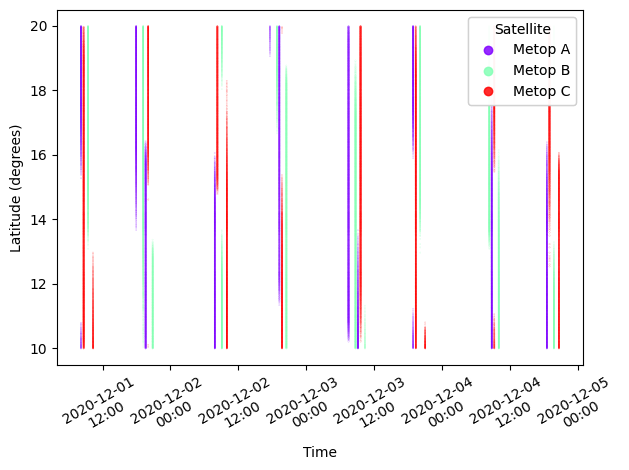

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
plt.close()
fig, ax = plt.subplots()
scatter = ax.scatter(output.time, output.longitude, s=0.01, c=output.sat_id, cmap="rainbow", alpha=0.8)
legend1 = ax.legend(*scatter.legend_elements(), title="Satellite")
for i in range(3):
    legend1.get_texts()[i].set_text(f"Metop {chr(65+i)}")
ax.add_artist(legend1)
plt.xlabel("Time")
plt.ylabel("Latitude (degrees)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
plt.xticks(rotation=30)
plt.tight_layout()

We can check the spatial coverage of the data by plotting it on a map.



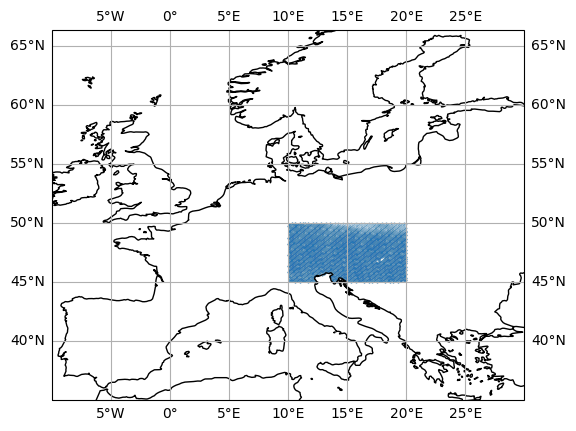

In [9]:
import cartopy.crs as ccrs
from shapely import Point

plt.close()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-10, 30, 35, 65])
plt.scatter(
    output.longitude,
    output.latitude,
    s=0.1,
    alpha=0.1
)

Having the data as an Xarray makes it handy to do transformations. For example, we can group by location<sub>id</sub> and get the average surface soil moisture at each. First, we need to load the `location_id` into memory, since it currently exists as a chunked dask array, and the groupby method only works with numpy arrays.



In [10]:
output["location_id"].load()

<xarray.DataArray 'location_id' (obs: 45007)>
array([1258693., 1259680., 1260057., ..., 1260222., 1260311., 1260455.])
Coordinates:
    latitude   (obs) float64 49.91 49.96 49.98 49.82 ... 49.98 49.99 49.99 50.0
    longitude  (obs) float64 19.94 19.78 19.35 19.84 ... 11.69 10.57 12.38 11.26
    time       (obs) datetime64[ns] 2020-12-01T08:09:59.415000064 ... 2020-12...
Dimensions without coordinates: obs
Attributes:
    long_name:  Location identifier (Grid Point ID)
    valid_min:  0
    valid_max:  3300000

In [11]:
%%time
avg_ssm = output["surface_soil_moisture"].groupby(output["location_id"]).mean("obs")
avg_ssm.load()

/home/charriso/micromamba/envs/egu2024/lib/python3.8/site-packages/flox/core.py:2004: PerformanceWarning: Slicing with an out-of-order index is generating 78 times more chunks
  result = result[..., sorted_idx]


CPU times: user 1.24 s, sys: 82.1 ms, total: 1.33 s
Wall time: 1.21 s


<xarray.DataArray 'surface_soil_moisture' (location_id: 2652)>
array([55.3      , 73.21357  , 54.573635 , ...,  3.9599998, 41.566666 ,
       25.1      ], dtype=float32)
Coordinates:
  * location_id  (location_id) float64 1.163e+06 1.163e+06 ... 1.26e+06 1.26e+06
Attributes:
    long_name:  surface soil moisture
    units:      percent saturation
    valid_min:  0
    valid_max:  10000

This takes ~1.2 seconds on my own machine, which isn&rsquo;t too bad, but we&rsquo;re only working with 5 days of data here for a relatively small area. This operation could easily balloon in complexity and become intractable, especially if it needs to be repeated often. We also get warnings about slicing with an out-of-order index.

However, if we use flox directly (a package from the developers of Xarray that is created to do faster groupbys with Xarray datasets), we can accomplish the same operation in a fraction of the time (~90ms on my machine). When scaling up to much longer time periods and larger surface areas, these savings can make a huge difference.



In [12]:
from flox.xarray import xarray_reduce

In [13]:
%%time
avg_ssm_flox = xarray_reduce(output["surface_soil_moisture"], output["location_id"], func="mean")
avg_ssm_flox.load()

CPU times: user 93.7 ms, sys: 14.4 ms, total: 108 ms
Wall time: 93.4 ms


<xarray.DataArray 'surface_soil_moisture' (location_id: 2652)>
array([55.3      , 73.21357  , 54.57363  , ...,  3.9599998, 41.566666 ,
       25.100002 ], dtype=float32)
Coordinates:
  * location_id  (location_id) float64 1.163e+06 1.163e+06 ... 1.26e+06 1.26e+06
Attributes:
    long_name:  surface soil moisture
    units:      percent saturation
    valid_min:  0
    valid_max:  10000

Note: if, when using flox, you get an error about needing to provide `expected_groups`, make sure you&rsquo;ve `load` -ed the variables you&rsquo;ll be grouping your data by into memory first. If your dataset is too big for that, you can calculate the unique values of those variables and pass them in a tuple to the `expected_groups` parameter. For example, if we want to calculate seasonal soil moisture averages per location, we can add a grouping of the `time` variable to our `xarray_reduce` arguments. However, if we haven&rsquo;t loaded `location_id` into memory yet, we&rsquo;ll get an error:



In [14]:
short_dates = (datetime(2020, 12, 1), datetime(2020, 12, 2))
ds = swath_collection.read(bbox=bounds, date_range=dates)
xarray_reduce(ds["surface_soil_moisture"], ds["location_id"], ds["time"].dt.hour, func="mean")

ValueError: Please provide expected_groups if not grouping by a numpy array.

We didn&rsquo;t get this error before because we had already loaded `location_id` into memory. Loading a single variable into memory shouldn&rsquo;t be much of a problem, but if it is, here&rsquo;s how you would use `expected_groups` to solve it instead:



In [15]:
import numpy as np
xarray_reduce(
    ds["surface_soil_moisture"],
    ds["location_id"],
    ds["time"].dt.hour,
    expected_groups=(np.unique(output["location_id"].values),
                     np.unique(output["time"].dt.hour.values)),
    func="mean"
).load()

<xarray.DataArray 'surface_soil_moisture' (location_id: 2652, hour: 9)>
array([[91.71     , 37.46     , 71.503334 , ..., 55.53     , 40.95     ,
               nan],
       [75.7      , 56.953327 , 63.656666 , ..., 80.432495 , 94.45     ,
               nan],
       [52.       , 42.173332 , 57.54333  , ..., 58.72333  ,        nan,
               nan],
       ...,
       [ 3.9599998,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 26.9      , 70.9      , ...,        nan,        nan,
               nan],
       [14.49     , 21.055    , 12.83     , ...,        nan, 31.404999 ,
               nan]], dtype=float32)
Coordinates:
  * location_id  (location_id) float64 1.163e+06 1.163e+06 ... 1.26e+06 1.26e+06
  * hour         (hour) int32 7 8 9 10 17 18 19 20 21
Attributes:
    long_name:  surface soil moisture
    units:      percent saturation
    valid_min:  0
    valid_max:  10000

I&rsquo;ll step away from the data for a second and write a quick function for plotting it on a map:



In [17]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

def simple_map(lons, lats, color_var, cmap, dates=None, cbar_label=None):
    plt.close()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.bottom_labels = False
    gl.right_labels = False
    ax.set_extent([lons.min()-5, lons.max()+5, lats.min()-5, lats.max()+5])
    # ax.set_extent([-10, 30, 35, 65])
    plt.scatter(
        lons,
        lats,
        c=color_var,
        cmap=cmap,
        s=1,
        # alpha=0.8,
        # clim=(0, 100)
    )
    if cbar_label is None:
        cbar_label = (
            f"Average {color_var.long_name}\n"
            f"({color_var.units})\n"
        )
    if dates is not None:
        cbar_label += f"\n{np.datetime_as_string(dates[0], unit='s')} - {np.datetime_as_string(dates[1], unit='s')}"

    plt.colorbar(label=(cbar_label),
                 shrink=0.5,
                 pad=0.05,
                 orientation="horizontal"
    )
    plt.tight_layout()

And here is our mean soil moisture!



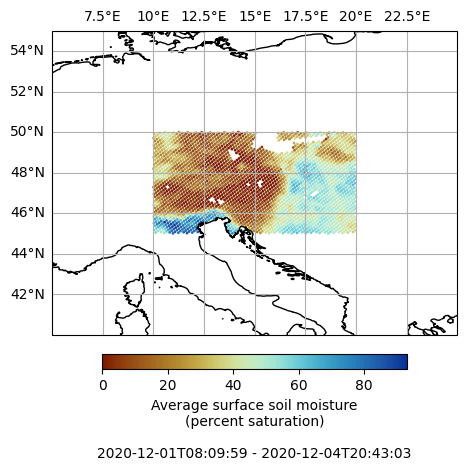

In [19]:
import cmcrameri.cm as cmc
lons, lats = swath_collection.grid.gpi2lonlat(avg_ssm_flox.location_id.values)
simple_map(lons, lats, avg_ssm_flox, cmc.roma, (output.time.values.min(), output.time.values.max()))

Now it&rsquo;s easy to make a map of any of the other variables in the dataset. Here&rsquo;s the average backscatter at 40 degrees incidence angle:



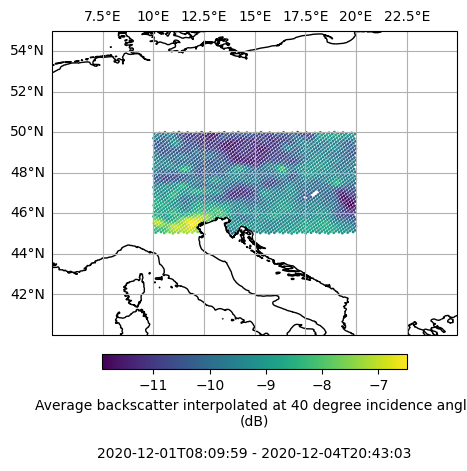

In [20]:
avg_backscatter40 = xarray_reduce(output["backscatter40"], output["location_id"], func="mean")
simple_map(lons, lats, avg_backscatter40, "viridis", (output.time.values.min(), output.time.values.max()))

Or we could make a timeseries plot of a variable at a single location or a collection of locations:



In [21]:
week_dates = (datetime(2020, 12, 1), datetime(2020, 12, 8))
week_data = swath_collection.read(date_range=week_dates, bbox=bounds)
date_groups = week_data.groupby("time.date")

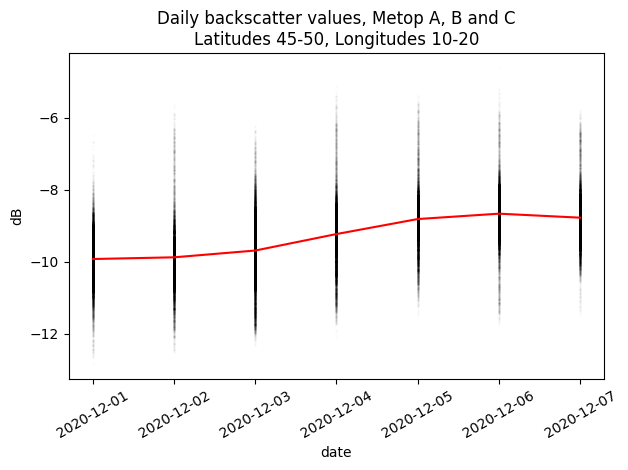

In [22]:
for dt, ds in date_groups:
    plt.scatter(ds["time.date"], ds.backscatter40, color="black", s=1, alpha=0.01)

plt.plot(date_groups.groups.keys(), date_groups.mean().backscatter40.values, color="red")

plt.title("Daily backscatter values, Metop A, B and C\n"
          "Latitudes 45-50, Longitudes 10-20")
plt.ylabel(f"{ds.backscatter40.units}")
plt.xlabel(f"date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=30)
plt.tight_layout()

We can make a 5-year climatology for our data in three lines of code, but it will take a while to run, since we&rsquo;ll have to read metadata from thousands of files to compile the xarray dataset. I do not recommend running this cell.


In [1]:
# five year climatology
five_years = [datetime(2015, 1, 1), datetime(2020, 1, 1)]
five_years_data = swath_collection.read(location_id=gpis, date_range=five_years)#.load()
climatology = output.groupby("time.dayofyear").mean("obs")

If you need to do several operations on larger chunks of time, it could be useful to convert the data to a cell file collection and work off of that. (see CellFileCollection section below)



### Converting swath collections to cell collections



To convert a collection of swath files into a collection of cell files, we only need to call a single method from our SwathFileCollection. We pass it at least an output directory path (`out_dir`), where the outputs will be written, and we can also pass it several other options.



In [1]:
# without setting this variable as False, the package will warn the user and wait for confirmation before running, since a careless use of `stack` pointing to the wrong directory could delete or ruin a lot of data.
rat.process_warnings = False
# where to save the files
cell_file_directory = ""
# a list of swath file names to write, if you have a specific list
fnames = None
# the date range to stack data from
date_range = None
# mode : "w" for creating new files if any already exist, "a" to append data to existing cell files
# note that old data and new data will not be sorted after the append
mode = "w"
# the number of processes to use when writing the data.
# does NOT have anything to do with xarray's dask processing
# I've found that using too many processes, even on machines with many cores, may not be optimal.
# A good number is 8.
processes = 8

# the maximum size of the data buffer before dumping to file (actual maximum memory used will be higher)
# default is 6144MB
buffer_memory_mb = None

# # This command commented to avoid accidental execution
# swath_collection.stack(
#     output_dir=cell_file_directory,
#     fnames=fnames,
#     date_range=date_range,
#     mode=mode,
#     processes=processes,
#     buffer_memory_mb=buffer_memory_mb
# )

The output cells are in *indexed ragged array* format. In order to convert them to *contiguous* ragged array format, we can create a `CellFileCollection` from the output directory, and call the method `to_contiguous()`:



In [1]:
cell_collection = rat.CellFileCollection.from_product_id(cell_file_directory, product_id="H121_v1.0")
contiguous_cell_file_directory = ""
cell_collection.to_contiguous(contiguous_cell_file_directory)

This will sort the entire dataset first by time and then by `locationIndex`, and then replace the dataset&rsquo;s `locationIndex` variable with a `row_size` variable. At this point it is no longer practically possible to append new data to the dataset without first re-converting it to indexed ragged array format and then converting back.



## Working with collections of cell files



Right now, although `CellFileCollection` exists, it currently is optimized for use under the hood of `CellFileCollectionStack`. Ideally both could be used by users, but there are still some bugs to be worked out and some refactoring to do. To work with a single collection of cell files, simply create a `CellFileCollectionStack` with a single collection inside.



## Working with stacks of cell file collections



### Creating a cell file collection



In [23]:
from datetime import datetime
from importlib import reload
from time import time

import ascat.read_native.ragged_array_ts as rat

Our cell files, in this case, all live in a single directory, so that&rsquo;s the path we&rsquo;ll pass to `rat.CellFileCollectionStack.from_product_id()`. If we had multiple sets of cell files contained in different directories, we could pass a list of these directories&rsquo; paths, assuming they were all of the same product type (and therefore had the same dimensions, data variables, etc).

The product id, `"H121_V1.0"`, refers to a specific handler class defined in `ascat.read_native.xarray_io`. There are several of these already defined for various products we use, and it is also possible to define your own handler class if you need to process a product we haven&rsquo;t included in this package already.



In [24]:
cell_source = "/home/charriso/p14/data-write/USERS/charriso/h121_merged/metop_abc/"
cell_collection = rat.CellFileCollectionStack.from_product_id(cell_source, "H121_V1.0")

/home/charriso/Projects/ascat/src/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'metop_abc' from directory name. Using min/max datetime from files instead.
  warnings.warn(


### Reading from a cell file collection



We can read data from a specific geographic and temporal extent, but if you have a single collection, it may actually take longer to create an xarray dataset if you try to trim down the time range. In this case it is best to only subset by geographic extent on read, and then do any temporal subsetting after the xarray dataset is created, but before the data is actually loaded into memory with `.load()`.

On the other hand, if you have a stack with multiple collections that cover different time ranges, you can possibly save a lot of time when reading using temporal subsetting. (Imagine you have dozens of weekly cell collections and only need two weeks - no need to even look at the other files).

Our options for geographic extent are `cell`, `bbox`, `geom`, and `location_id`. `cell` is a list of cell indices, `bbox` is a tuple of (latmin, latmax, lonmin, lonmax), `geom` is a shapely geometry object, and `location_id` is a list of location indices.



In [25]:
bounds = (43, 51, 11, 21) #latmin, latmax, lonmin, lonmax
dates = (np.datetime64(datetime(2020, 12, 1)), np.datetime64(datetime(2020, 12, 15)))

In [26]:
output_bbox = cell_collection.read(bbox=bounds)#, date_range=dates)
output_bbox

<xarray.Dataset>
Dimensions:                            (obs: 59143813, locations: 4378)
Coordinates:
    time                               (obs) datetime64[ns] 2007-01-01T08:00:...
    lon                                (locations) float32 ...
    lat                                (locations) float32 ...
    alt                                (locations) float32 ...
Dimensions without coordinates: obs, locations
Data variables: (12/22)
    locationIndex                      (obs) int64 ...
    as_des_pass                        (obs) float32 ...
    swath_indicator                    (obs) float32 ...
    surface_soil_moisture              (obs) float32 ...
    surface_soil_moisture_noise        (obs) float32 ...
    backscatter40                      (obs) float32 ...
    ...                                 ...
    topographic_complexity             (obs) float32 ...
    subsurface_scattering_probability  (obs) float32 ...
    global_attributes_flag             (locations) int64 ...
    sat_id                             (obs) float32 ...
    location_id                        (locations) int64 ...
    location_description               (locations) object ...
Attributes: (12/15)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    disposition_mode:  Operational
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries

In [27]:
date_range_data = output_bbox.sel(obs=(output_bbox["time"] > dates[0]) & (output_bbox["time"] < dates[1]))
date_range_data

<xarray.Dataset>
Dimensions:                            (obs: 226965, locations: 4378)
Coordinates:
    time                               (obs) datetime64[ns] 2020-12-01T08:11:...
    lon                                (locations) float32 ...
    lat                                (locations) float32 ...
    alt                                (locations) float32 ...
Dimensions without coordinates: obs, locations
Data variables: (12/22)
    locationIndex                      (obs) int64 ...
    as_des_pass                        (obs) float32 ...
    swath_indicator                    (obs) float32 ...
    surface_soil_moisture              (obs) float32 ...
    surface_soil_moisture_noise        (obs) float32 ...
    backscatter40                      (obs) float32 ...
    ...                                 ...
    topographic_complexity             (obs) float32 ...
    subsurface_scattering_probability  (obs) float32 ...
    global_attributes_flag             (locations) int64 ...
    sat_id                             (obs) float32 ...
    location_id                        (locations) int64 ...
    location_description               (locations) object ...
Attributes: (12/15)
    title:             ASCAT surface soil moisture near real-time product
    summary:           ASCAT surface soil moisture expressed in degree of sat...
    doi:               unset
    keywords:          Metop-A ASCAT surface soil moisture
    history:           original generated product
    institution:       H SAF
    ...                ...
    disposition_mode:  Operational
    environment:       Operational
    references:        h-saf.eumetsat.int
    software_version:  warp_h_nrt 0.0.0
    conventions:       CF-1.10
    featureType:       timeSeries

Now let&rsquo;s map the average surface soil moisture over the area and time range we selected.



In [28]:
from flox.xarray import xarray_reduce
avg_sm = xarray_reduce(date_range_data["surface_soil_moisture"], date_range_data["locationIndex"], func="mean")
avg_sm

<xarray.DataArray 'surface_soil_moisture' (locationIndex: 4000)>
array([73.23913 , 85.52    , 52.248085, ..., 64.45    , 35.750626,
       62.632   ], dtype=float32)
Coordinates:
  * locationIndex  (locationIndex) int64 1 2 4 5 6 ... 4373 4374 4375 4376 4377
Attributes:
    long_name:    surface soil moisture
    units:        percent saturation
    valid_min:    0
    valid_max:    10000
    coordinates:  time latitude longitude

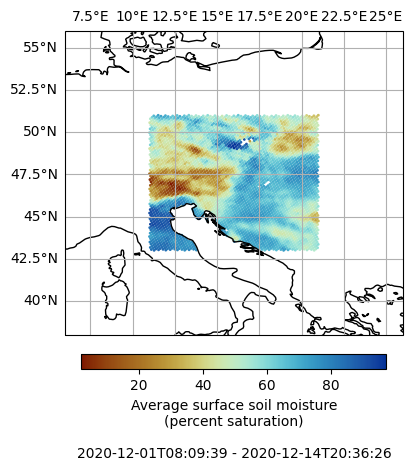

In [29]:
import numpy as np
lons = date_range_data.lon.values[avg_sm.locationIndex.values]
lats = date_range_data.lat.values[avg_sm.locationIndex.values]
simple_map(lons, lats, avg_sm, cmc.roma, (date_range_data.time.values.min(), date_range_data.time.values.max()))

When we read data using cell ids, the process is just as easy:



In [30]:
output_cells = cell_collection.read(cell=[1431, 1432, 1395, 1396])

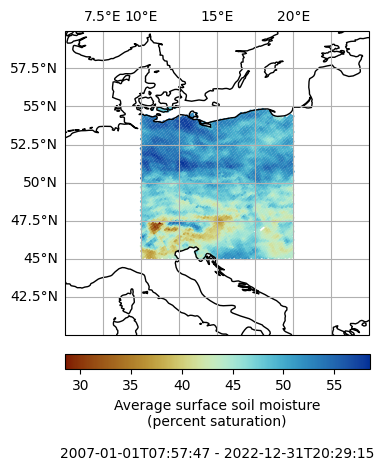

In [31]:
avg_sm = xarray_reduce(output_cells["surface_soil_moisture"], output_cells["locationIndex"], func="mean")
lons = output_cells.lon.values[avg_sm.locationIndex.values]
lats = output_cells.lat.values[avg_sm.locationIndex.values]
simple_map(lons, lats, avg_sm, cmc.roma, (output_cells.time.values.min(), output_cells.time.values.max()))

I forgot to filter by time range, but it took flox only a few seconds to calculate the average surface soil moisture over the entire time range of the dataset for these cells!



#### Using geometries



If you have a shapefile you would like to use to filter your data, you will have to turn it into a shapely geometry object. There are a few ways you could do this (using geopandas, fiona, or ogr, for example). This function uses cartopy&rsquo;s shapereader to fetch a world country boundaries shapefile from Natural Earth, and then uses shapely to create a geometry object from the desired country names.



In [32]:
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union

def get_country_geometries(country_names, resolution="10m", ne_product="admin_0_countries"):
    countries = shpreader.Reader(
        shpreader.natural_earth(
            resolution=resolution,
            category="cultural",
            name=ne_product,
        )
    ).records()
    if isinstance(country_names, str):
        country_names = [country_names]
    for i in range(len(country_names)):
        country_names[i] = country_names[i].lower()

    geometries = []
    desired_shp = None
    for loop_country in countries:
        if loop_country.attributes["SOVEREIGNT"].lower() in country_names:
            desired_shp = loop_country.geometry
            if desired_shp is not None:
                geometries.append(desired_shp)
    return unary_union(geometries)

If we are interested in the Baltic countries, for example, we can simply pass a list of their names to `get_country_geometries`, then pass the resulting geometry to the `geom` argument of `cell_collection.read()`.



In [33]:
baltics = ["Estonia", "Latvia", "Lithuania"]
country_data = cell_collection.read(geom=get_country_geometries(baltics))

Groupby operations are easy with flox. Here we calculate the average summer soil moisture for each location in the Baltics across the entire time range of the dataset.



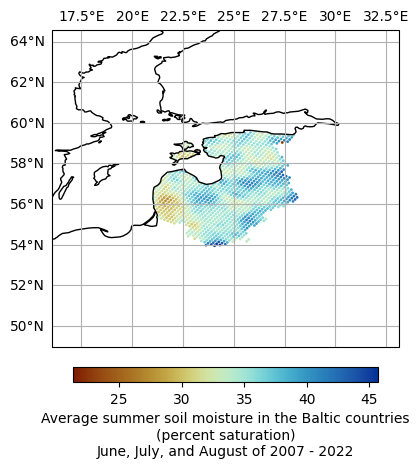

In [34]:
import numpy as np
from flox.xarray import xarray_reduce

baltic_summer = country_data.sel(obs=(country_data.time.dt.season == "JJA"))
avg_sm = xarray_reduce(baltic_summer["surface_soil_moisture"], baltic_summer["locationIndex"], func="mean")
lons = country_data.lon.values[avg_sm.locationIndex.values]
lats = country_data.lat.values[avg_sm.locationIndex.values]
label = (
        f"Average summer soil moisture "
        f"in the Baltic countries\n"
        f"({avg_sm.units})\n"
        f"June, July, and August of 2007 - 2022"
)
simple_map(lons, lats, avg_sm, cmc.roma, cbar_label=label)

Remember that climatology we were going to make in the swaths section? Let&rsquo;s do that now, it&rsquo;s simple:



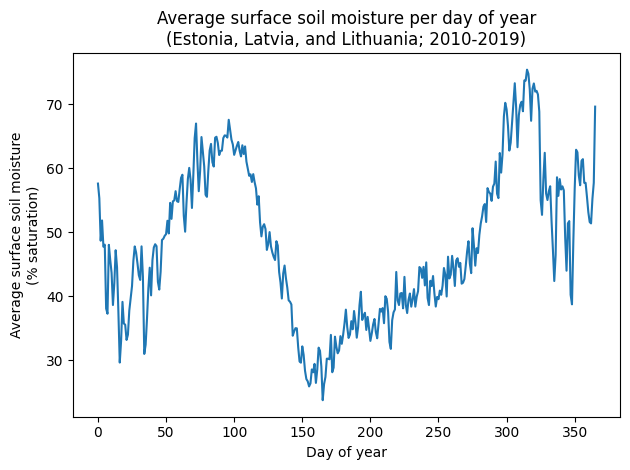

In [35]:
# 15-year climatology
ssm_climatology = xarray_reduce(country_data["surface_soil_moisture"], country_data["time"].dt.dayofyear, func="mean")
plt.close()
plt.plot(ssm_climatology)
plt.xlabel("Day of year")
plt.ylabel("Average surface soil moisture\n(% saturation)")
plt.title("Average surface soil moisture per day of year\n(Estonia, Latvia, and Lithuania; 2010-2019)")
plt.tight_layout()